In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv
import pandas as pd 
import sys
%matplotlib inline
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + mpl.__version__)

Python version 3.7.2 (default, Jan 16 2019, 19:49:22) 
[GCC 8.2.1 20181215 (Red Hat 8.2.1-6)]
Pandas version 0.24.1
Matplotlib version 3.0.2


In [2]:
old_output_path = '../outputs/out_conf2_ssd_hdd_sam_refctrd_old.csv'
new_output_path = '../outputs/out_conf2_ssd_hdd_sam_refactored.csv'
old_sam = pd.read_csv(old_output_path)
new_sam = pd.read_csv(new_output_path)

In [3]:
def beautify_strategy_field(df):
    df['strategy']=df['strategy'].map(lambda name : name.split('.')[1].lower())

beautify_strategy_field(old_sam)
beautify_strategy_field(new_sam)

In [4]:
old_sam.head()

,sample,hardware_type,file_system,strategy,split_time,merge_time,split_nb_seeks,merge_nb_seeks,split_read_time,merge_read_time,split_write_time,merge_write_time,split_seek_time,merge_seek_time
0,bigBrainSample1-1-1.nii,ssd,ext4,clustered,37.460476,51.141387,2824,3388009,23.185240,0.054425,2.247390,20.574880,0.000037,11.869009
1,bigBrainSample1-0-1.nii,hdd,ext4,multiple,69.259714,99.360231,0,3388011,19.865430,0.003855,2.269568,33.627498,0.000072,13.952327
2,bigBrainSample1-0-1.nii,hdd,ext4,clustered,100.954287,103.586279,2824,3388009,86.524888,0.048033,2.625423,47.951994,0.000038,11.796845
3,bigBrainSample1-1-0.nii,hdd,ext4,multiple,70.634462,101.300133,0,3388011,20.340792,0.003924,2.235124,34.197365,0.000072,14.620254
4,bigBrainSample0-1-1.nii,hdd,ext4,multiple,65.184196,102.603732,0,3388011,14.912413,0.004295,2.277185,35.074840,0.000071,14.487036


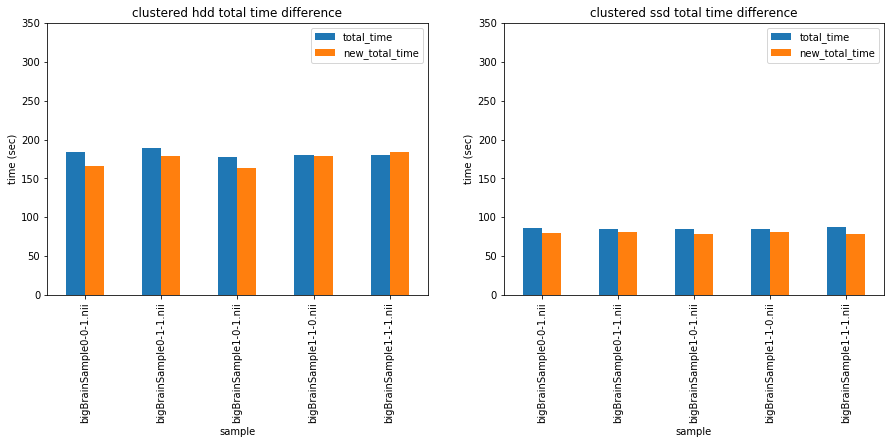

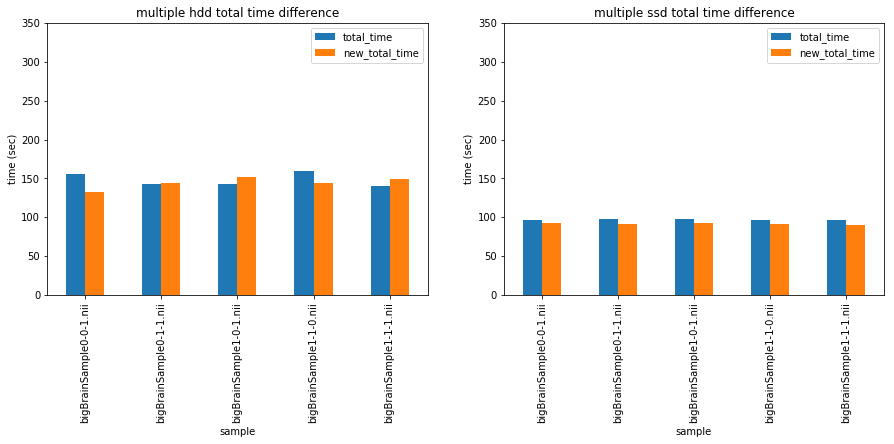

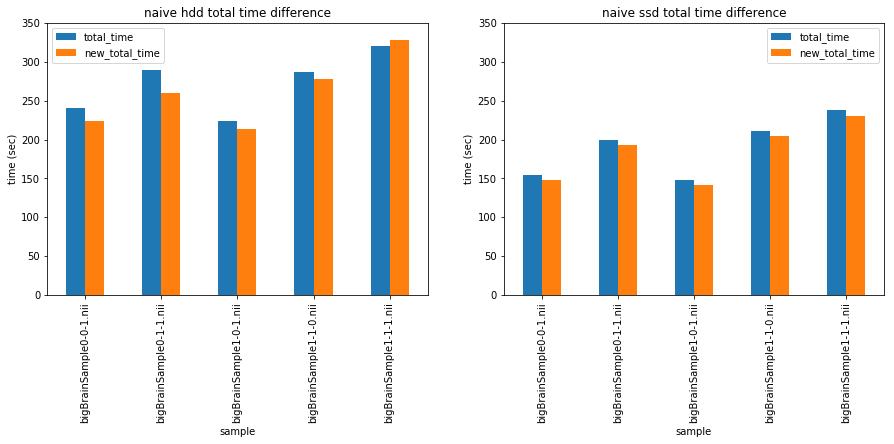

In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 

def set_axes(data, index, axes, rot):
    axes.set_xticklabels(data.index, rotation=rot)
    axes.set_ylabel("time (sec)")

def total_time_hardware_stacked(clustered_df_hdd, plot_title):
    group_hdd = clustered_df_hdd[['sample', 'hardware_type', 'sam', 'total_time']] \
        .groupby(['sample','hardware_type', 'sam'], as_index=False) \
        .agg([np.mean])
    print(group_hdd)
    
    group_hdd.columns=group_hdd.columns.droplevel(1)
    group_hdd.index=group_hdd.index.droplevel('hardware_type')
    
    return group_hdd, plot_title
    
def get_max(tmpf_df):
    return tmpf_df['total_time'].max()
    
def compare_stacked(strategy):
    old_clustered_df = old_sam[old_sam.strategy == strategy]
    new_clustered_df = new_sam[new_sam.strategy == strategy]

    old_df = old_clustered_df[['sample', 'hardware_type', 'split_time', 'merge_time']]
    old_df['sam'] = ['old']*old_df.shape[0]
    new_df = new_clustered_df[['sample', 'hardware_type', 'split_time', 'merge_time']]
    new_df['sam'] = ['new']*new_df.shape[0]

    #split hdd and ssd
    old_clustered_df_hdd = old_df[old_df['hardware_type']=='hdd']
    new_clustered_df_hdd = new_df[new_df['hardware_type']=='hdd']
    old_clustered_df_ssd = old_df[old_df['hardware_type']=='ssd']
    new_clustered_df_ssd = new_df[new_df['hardware_type']=='ssd']
    
    #compute total time
    old_clustered_df_hdd['total_time'] = old_clustered_df_hdd['split_time'] + old_clustered_df_hdd['merge_time']
    new_clustered_df_hdd['total_time'] = new_clustered_df_hdd['split_time'] + new_clustered_df_hdd['merge_time']
    old_clustered_df_ssd['total_time'] = old_clustered_df_ssd['split_time'] + old_clustered_df_ssd['merge_time']
    new_clustered_df_ssd['total_time'] = new_clustered_df_ssd['split_time'] + new_clustered_df_ssd['merge_time']
    
    #compute means by sample
    old_clustered_df_hdd = old_clustered_df_hdd[['sample', 'hardware_type', 'sam', 'total_time']] \
        .groupby('sample').mean().sort_values('sample')
    new_clustered_df_hdd = new_clustered_df_hdd[['sample', 'hardware_type', 'sam', 'total_time']] \
        .groupby('sample').mean().sort_values('sample')
    old_clustered_df_ssd = old_clustered_df_ssd[['sample', 'hardware_type', 'sam', 'total_time']] \
        .groupby('sample').mean().sort_values('sample')
    new_clustered_df_ssd = new_clustered_df_ssd[['sample', 'hardware_type', 'sam', 'total_time']] \
        .groupby('sample').mean().sort_values('sample')
    
    old_clustered_df_hdd['new_total_time'] = new_clustered_df_hdd['total_time']
    old_clustered_df_ssd['new_total_time'] = new_clustered_df_ssd['total_time']
    
    fig, axes = plt.subplots(1, 2,figsize=(15,5))
    old_clustered_df_hdd.plot(kind='bar', ax=axes[0]).set_title(strategy + ' hdd total time difference')
    old_clustered_df_ssd.plot(kind='bar', ax=axes[1]).set_title(strategy + ' ssd total time difference')
    axes[0].set_ylim([0,350])
    axes[1].set_ylim([0,350])
    
    set_axes(old_clustered_df_hdd, 'none', axes[0], 90)
    set_axes(old_clustered_df_ssd, 'none', axes[1], 90)
    
compare_stacked('clustered')
compare_stacked('multiple')
compare_stacked('naive')

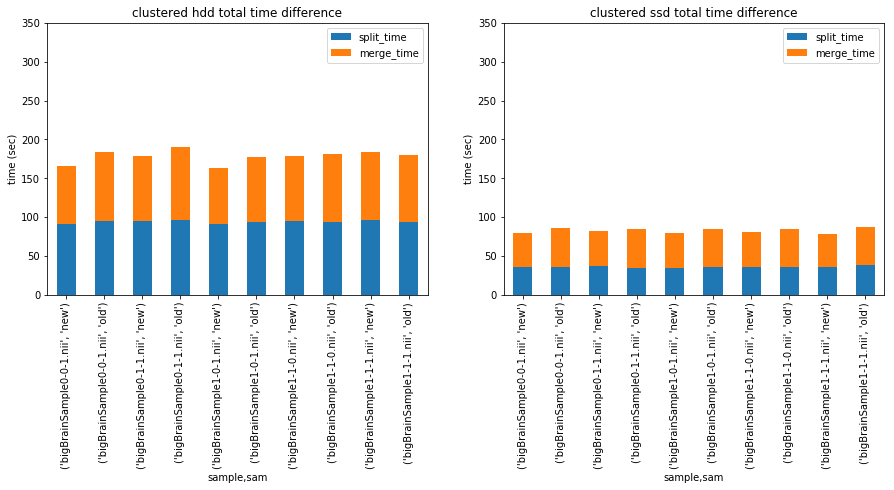

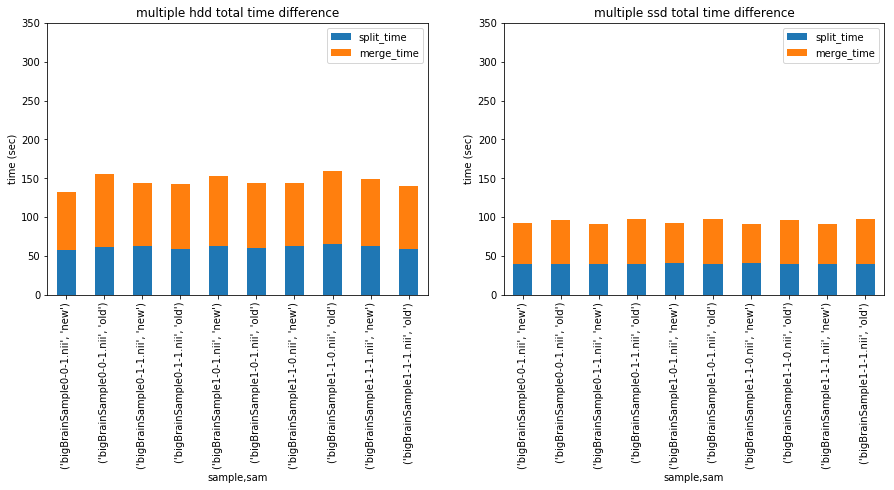

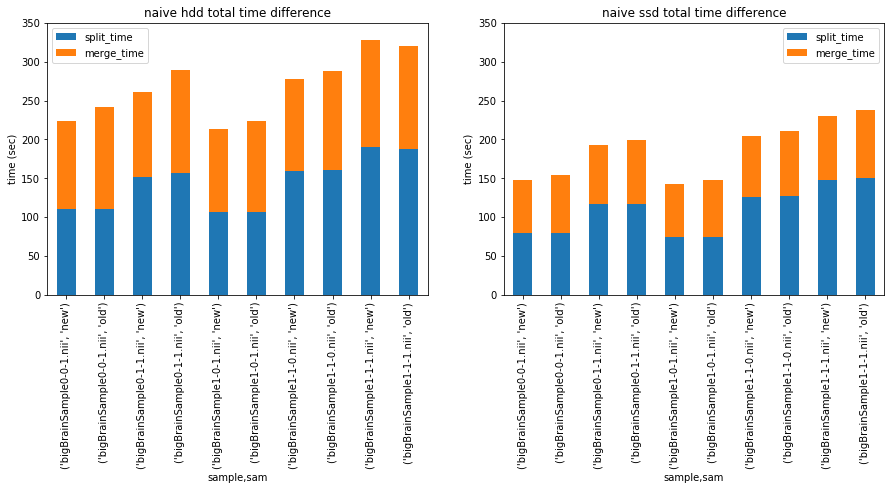

In [6]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 

def set_axes(data, index, axes, rot):
    axes.set_xticklabels(data.index, rotation=rot)
    axes.set_ylabel("time (sec)")

def total_time_hardware_stacked(clustered_df_hdd, plot_title):
    group_hdd = clustered_df_hdd \
        .groupby(['sample','hardware_type', 'sam'], as_index=False) \
        .agg([np.mean])
    
    group_hdd.columns=group_hdd.columns.droplevel(1)
    group_hdd.index=group_hdd.index.droplevel('hardware_type')
    
    return group_hdd, plot_title
    
def get_max(tmpf_df):
    return max([tmpf_df['split_time'].max(),tmpf_df['merge_time'].max()])
    
def compare_stacked(strategy):
    old_clustered_df = old_sam[old_sam.strategy == strategy]
    new_clustered_df = new_sam[new_sam.strategy == strategy]

    old_df = old_clustered_df[['sample', 'hardware_type', 'split_time', 'merge_time']]
    old_df['sam'] = ['old']*old_df.shape[0]
    new_df = new_clustered_df[['sample', 'hardware_type', 'split_time', 'merge_time']]
    new_df['sam'] = ['new']*new_df.shape[0]

    old_clustered_df_hdd = old_df[old_df['hardware_type']=='hdd']
    new_clustered_df_hdd = new_df[new_df['hardware_type']=='hdd']
    old_clustered_df_ssd = old_df[old_df['hardware_type']=='ssd']
    new_clustered_df_ssd = new_df[new_df['hardware_type']=='ssd']

    hdd_df = old_clustered_df_hdd.append(new_clustered_df_hdd)
    ssd_df = old_clustered_df_ssd.append(new_clustered_df_ssd)
    
    fig, axes = plt.subplots(1, 2,figsize=(15,5))
    
    group_hdd, plot_title_hdd = total_time_hardware_stacked(hdd_df, strategy + ' hdd total time difference')
    group_ssd, plot_title_ssd = total_time_hardware_stacked(ssd_df, strategy + ' ssd total time difference')

    group_hdd.plot(kind='bar', ax=axes[0], stacked=True).set_title(plot_title_hdd)
    group_ssd.plot(kind='bar', ax=axes[1], stacked=True).set_title(plot_title_ssd)
    axes[0].set_ylim([0,350])
    axes[1].set_ylim([0,350])
    
    set_axes(group_hdd, 'none', axes[0], 90)
    set_axes(group_ssd, 'none', axes[1], 90)
    
compare_stacked('clustered')
compare_stacked('multiple')
compare_stacked('naive')